In [1]:
import sys, os

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np

from model_fitting import initialize_fitting 
from analyze_fits import analyze_gabor_params
from utils import default_paths

from analyze_features import load_feature_stats

import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import load_fits, plot_utils

In [2]:
# Load everything

models = initialize_fitting.get_prf_models(which_grid=5)
n_prfs = len(models)
feature_type='gabor_solo'
which_prf_grid=5

subjects = np.arange(1,9)
trial_subset_list=['all', \
                   'balance_indoor_outdoor','outdoor_only', 'indoor_only',\
                   'balance_animacy', 'animate_only', 'inanimate_only', \
                   'balance_real_world_size_binary', 'large_only', 'small_only']
path_to_load = os.path.join(default_paths.gabor_texture_feat_path, 'feature_stats')

n_trial_subsets = len(trial_subset_list)

n_features = 96;
n_subjects=len(subjects)

meanvals = np.zeros((n_subjects, n_trial_subsets, n_features, n_prfs))
varvals = np.zeros((n_subjects, n_trial_subsets, n_features, n_prfs))

for si, ss in enumerate(subjects):
    for ti, trial_subset in enumerate(trial_subset_list):
        
        if ti==0:
            fn2load1 = os.path.join(path_to_load, 'S%s_%s_mean_grid%d.npy'\
                                     %(ss, feature_type, which_prf_grid))
            fn2load2 = os.path.join(path_to_load, 'S%s_%s_var_grid%d.npy'\
                                     %(ss, feature_type, which_prf_grid))
            mean = np.load(fn2load1)
            meanvals[si,ti,:,:] = mean
            var = np.load(fn2load2)
            varvals[si,ti,:,:] = var
        else:  
            fn2load1 = os.path.join(path_to_load, 'S%s_%s_mean_grid%d_%s.npy'\
                                         %(ss, feature_type, which_prf_grid, trial_subset))
            fn2load2 = os.path.join(path_to_load, 'S%s_%s_var_grid%d_%s.npy'\
                                         %(ss, feature_type, which_prf_grid, trial_subset))
            mean = np.load(fn2load1)
            meanvals[si,ti,:,:] = mean[:,:,0] # training data only 
            var = np.load(fn2load2)
            varvals[si,ti,:,:] = var[:,:,0]

In [3]:
# Gather information about the gabor feature channels
sf_unique, ori_unique = analyze_gabor_params.get_gabor_feature_info(n_ori=12, n_sf=8)
n_sf = len(sf_unique)
n_ori = len(ori_unique)

 

In [75]:
colors_outdoor = np.flipud(cm.Greens(np.linspace(0,1,3))[1:3,:])
colors_outdoor = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_outdoor], axis=0)

colors_animacy = np.flipud(cm.Reds(np.linspace(0,1,5))[[1,3],:])
colors_animacy = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_animacy], axis=0)

colors_size = np.flipud(cm.Blues(np.linspace(0,1,3))[1:3,:])
colors_size = np.concatenate([np.array([[0.6, 0.6, 0.6, 1]]), colors_size], axis=0)

colors_categ = [colors_outdoor, colors_animacy, colors_size]

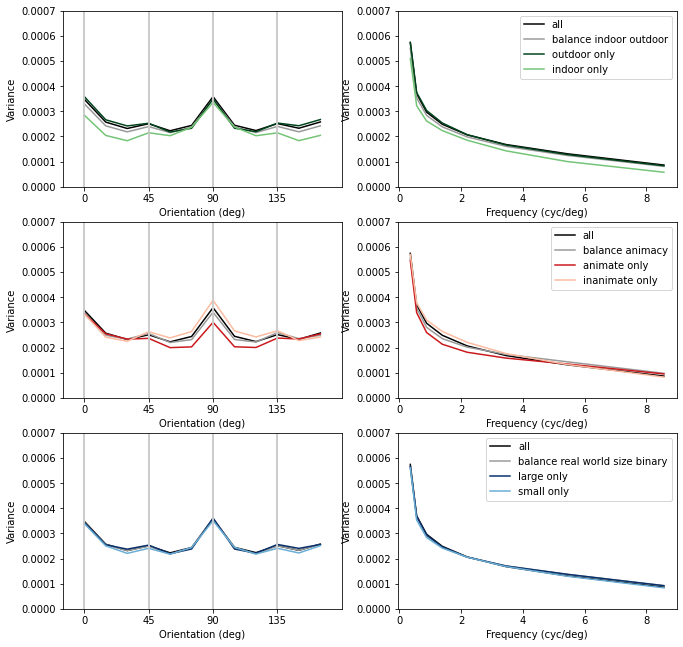

In [39]:
plt.rcParams['pdf.fonttype']=42

lims = [0, 0.0007]

groups = [[0,1,2,3],[0,4,5,6],[0,7,8,9]]

plt.figure(figsize=(11,11));

pi=-1
plot_order = np.arange(1,7)
# plot_order = [1,4,2,5,3,6]

for gi, group in enumerate(groups):

    colors_use = colors_categ[gi]
    colors_use = np.concatenate([np.array([[0, 0, 0, 1]]), colors_use], axis=0)
    
    names = [trial_subset_list[gg] for gg in group]

    pi+=1
    plt.subplot(3,2,plot_order[pi])
   
    for color_ind, ti in enumerate(group):

        var = np.mean(varvals[:,ti,:,:], axis=0)
        var_reshaped = np.reshape(var, [n_ori, n_sf, n_prfs], order = 'F')
        var_plot = np.min(var_reshaped, axis=2)
        
        plt.plot(ori_unique, np.mean(var_plot, axis=1), color=colors_use[color_ind,:])
        plt.xlabel('Orientation (deg)');
        plt.ylabel('Variance');
        # plt.yticks([])
        plt.xlim([-15, 180])
        for ii in np.arange(0,180,45):
            plt.axvline(ii, color=[0.8, 0.8, 0.8])
        plt.ylim(lims)
        plt.xticks(np.arange(0,180,45))

    pi+=1
    plt.subplot(3,2,plot_order[pi])
       
    for color_ind, ti in enumerate(group):

        var = np.mean(varvals[:,ti,:,:], axis=0)
        var_reshaped = np.reshape(var, [n_ori, n_sf, n_prfs], order = 'F')
        var_plot = np.min(var_reshaped, axis=2)
        
        plt.plot(sf_unique, np.mean(var_plot, axis=0), color=colors_use[color_ind,:])
        plt.xlabel('Frequency (cyc/deg)');
        plt.ylabel('Variance');
        # plt.yticks([])
        plt.ylim(lims)

    plt.legend([nn.replace('_', ' ') for nn in names])

fn2save = os.path.join(default_paths.fig_path,'Variance_trial_subsets.pdf')
plt.savefig(fn2save)